# First Passage Times: the Kramers problem

This tutorial illustrates the use of the `stochpy` package for first-passage time computations in the context of the Kramers problem [1] (diffusion in a double well potential). 
Here, we simply compute numerically the rate of transition between the two attractors.

## References

- [1] Kramers, Physica, 7, 284-304 (1940)
- [2] Gardiner, Handbook of Stochastic Methods, Springer, chap. 9 and §5.5.
- [3] Risken, The Fokker-Planck equation, Springer, §5.10
- [4] Caroli, Caroli and Roulet, J. Stat. Phys., 21, 415-437 (1979)
- [5] Caroli, Caroli and Roulet, J. Stat. Phys., 26, 83-111 (1981)
- [6] Hanggi, Talkner, Borkovec, Rev. Mod. Phys., 62, 251-342 (1990)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import stochpy as sp

Let us define the `DoubleWell` class, corresponding to a simple bistable system, by subclassing the generic 1D diffusion class `ConstantDiffusionProcess1D`:

In [2]:
class DoubleWell(sp.dynamics.diffusion1d.ConstantDiffusionProcess1D):
    """ 
    Double well potential model.
    """
    default_dt = 0.01

    def __init__(self, Damp, **kwargs):
        sp.dynamics.diffusion1d.ConstantDiffusionProcess1D.__init__(self, lambda x, t: -x*(x**2-1), Damp, **kwargs)

    def potential(self, X, t):
        """
        Return the value of the potential at the input points.
        """
        Y = X**2
        return Y*(Y-2.0)/4.0

The dynamics is given by the stochastic differential equation:
$$ dX_t = -V'(X_t)dt+\sqrt{2D}dW_t,$$
with $V(x)=x^4/4-x^2/2$.

## Qualitative understanding

### Deterministic dynamics

Let us first look at the dynamics for the deterministic system: we plot below the phase portrait of the system, superimposed upon the potential.

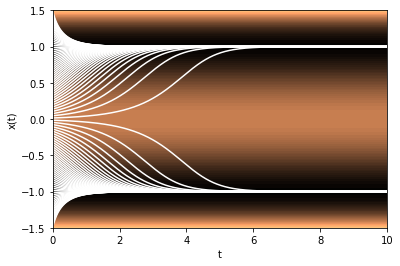

In [3]:
ax = plt.axes(xlabel='t', ylabel='x(t)')
X = np.linspace(-1.5, 1.5, num=100)
ax.contourf(np.linspace(0, 10), X, np.tile(DoubleWell(0).potential(X, 0), (50, 1)).T, 50, cmap='copper')
for x0 in X:
    ax.plot(*DoubleWell(0).trajectory(x0, 0, T=10), color='white')

$x=-1$ and $x=1$ are stable fixed points with basins of attraction $]-\infty,0[$ and $]0,+\infty[$, respectively, separated by an unstable fixed point at $x=0$.
Typical relaxation time is of order one but diverges as $x_0$ goes to 0.

### Noise-induced transitions between the two attractors

When the diffusion coefficient does not vanish, one should expect transitions between the two attractors. Let us illustrate this below with a moderate value of the noise.

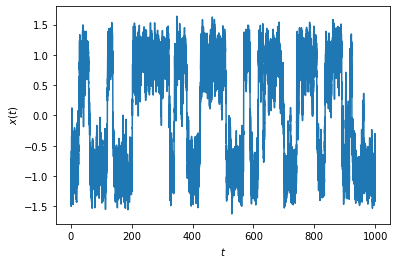

In [4]:
DoubleWell.trajectoryplot(DoubleWell(0.1, deterministic=True).trajectory(-1, 0, T=1000, dt=0.01));

The stationary distribution of the system should therefore be bimodal. It is simply given by $e^{-V(x)/D}$, up to a normalization factor. Let us compute this stationary distribution numerically by solving the Fokker-Planck equation with absorbing boundary conditions at a sufficient distance.

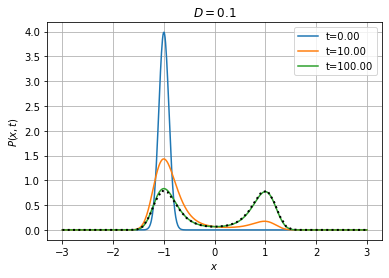

In [5]:
_, ax = DoubleWell(0.1).pdfplot(0.0, 10.0, 100.0, dt=0.0005, npts=600, bounds=(-3.0, 3.0), 
                                P0=sp.fokkerplanck.FokkerPlanck1D.gaussian1d(-1, 0.1, np.linspace(-3, 3, 600)));
x = np.linspace(-3, 3)
V = DoubleWell(0.1).potential(x, 0)
ax.plot(x, np.exp(-V/0.1)/np.trapz(np.exp(-V/0.1), x=x), color='black', ls='dotted', lw=2);

Particles initially concentrated in the left well *tunnel* through the potential barrier, and ultimately the relative probability of the two attractors is the same (because the quasi-potential is symmetric).

To study the statistical properties of the transitions between the two attractors, we introduce the *first-passage time*:
$$\tau_M = \inf \{ t>0, X_t > M | x_0=-1 \}.$$
It is a random variable entirely determined by the stochastic process $X$.
In `stochpy`, it can be represented by the `FirstPassageProcess` class:

In [6]:
tau = sp.firstpassage.FirstPassageProcess(DoubleWell(0.1))

Methods of the `FirstPassageProcess` class allow for sampling the random variable, estimating its mean, moments and PDF, using direct simulation or using the Fokker-Planck equation.

In [7]:
tau_samples = tau.escapetime_sample(-1, 0, 0.5, ntraj=10000)

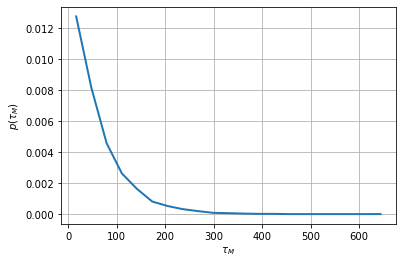

In [8]:
tau.escapetime_pdfplot(tau.escapetime_pdf(tau_samples))

The same result can be obtained by solving the Fokker-Planck equation for the transition probability $P(x, t | -1, 0)$ with a reflecting boundary condition on the left side of the domain (sufficiently far) and an absorbing condition at $x=M$. Then $G(x_0, t)=\int_{-\infty}^M P(x, t | x_0, 0) dx$, with $x_0=-1$ is the probability that the particle is still in the domain after time $t$, i.e. $P[\tau_M > t]$. Taking the opposite of the derivative with respect to time, we obtain the PDF of the first-passage time.

This computation can be done using the method `firstpassagetime_cdf`:

In [9]:
tFP, pFP = tau.firstpassagetime_cdf(-1.0, 0.5, *np.arange(10.0, 201.0, 10.0), dt=0.0001, 
                                    out='pdf', npts=200, bounds=(-4.0,0.5))

In fact, the function $G$ defined above satisfies the backwards Fokker-Planck equation. It can therefore be computed directly using the adjoint Fokker-Planck operator:

In [10]:
tFPb, pFPb = tau.firstpassagetime_cdf_adjoint(-1.0, 0.5, *np.arange(10.0, 201.0, 10.0), dt=0.0001, 
                                              out='pdf', npts=200, bounds=(-4.0,0.5))

When the noise is small enough, it is expected that the transition times are Poisson distributed. Their statistics is entirely determined by the transition rate (the parameter of the Poisson distribution), which is the inverse of the average time between two transitions.

Let us compare the PDF of the first-passage time computed in the three ways mentioned above with the Poisson distribution, estimating the parameter from the Monte-Carlo simulation.

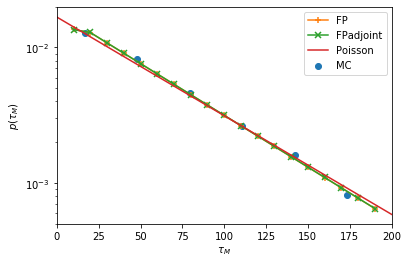

In [11]:
ax = plt.axes(xlabel=r'$\tau_M$', ylabel=r'$p(\tau_M)$', yscale='log', ylim=(5e-4, 2e-2), xlim=(0, 200))
ax.scatter(*tau.escapetime_pdf(tau_samples), label='MC');
t = np.linspace(*ax.get_xlim())
ax.plot(tFP, pFP, label='FP',marker='+',markeredgewidth=1.5, color='C1')
ax.plot(tFPb, pFPb, label='FPadjoint',marker='x',markeredgewidth=1.5, color='C2')
ax.plot(t, np.exp(-t/np.mean(tau_samples))/np.mean(tau_samples), color='C3', label='Poisson');
ax.legend();

## Computing the transition rate

Let us now study what determines the transition rate, or equivalently, the mean first-passage time.
For 1D homogeneous processes, a theoretical result can be obtained analytically:
$$ \mathbb{E}[\tau_M] = \frac{1}{D} \int_{-1}^{M} dx e^{V(x)/D} \int_{-\infty}^x e^{-V(y)/D}dy.$$
In the small noise limit $D \to 0$, a saddle-point approximation yields the Eyring-Kramers formula:
$$ \mathbb{E}[\tau_M] \approx \frac{2\pi}{\sqrt{|V''(0)V''(-1)|}}e^{\Delta V/D},$$
for $M> 0$ and $\Delta V=V(0)-V(-1)=1/4$ here.

In [12]:
mfpt_mc = np.array([sp.firstpassage.FirstPassageProcess(DoubleWell(D)).escapetime_avg(-1, 0, 0.5, ntraj=1000)
                    for D in 1./np.arange(1, 11)])

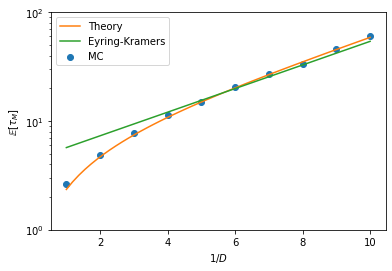

In [13]:
ax = plt.axes(xlabel=r'$1/D$', ylabel=r'$\mathbb{E}[\tau_M]$', yscale='log', ylim=(1, 100))
ax.scatter(np.arange(1, 11), mfpt_mc, label='MC');
invD = np.linspace(1, 10)
ax.plot(invD, np.array([sp.firstpassage.FirstPassageProcess(DoubleWell(D)).firstpassagetime_avg_theory(-1, 0.5) 
                        for D in 1./invD])[:, 1, 0], label='Theory', color='C1')
ax.plot(invD, np.sqrt(2)*np.pi*np.exp(0.25*invD), label='Eyring-Kramers', color='C2')
ax.legend();

The code also allows for computing the mean first passage time using the Fokker-Planck equation or its adjoint. We will soon update this notebook to show this method.

One could also show how the prefactor of the first-passage time depends on the threshold $M$ (above we chose $M=0.5$), for a fixed noise amplitude $D$. For $D$ small enough, there is a sharp transition around $M=0$, and the first-passage time depends very little on $M$ away from this boundary layer (and it is given by the above Eyring-Kramers formula).
In general, the expression of the first-passage time is always given by the integral formula before the saddle-point approximation.

Finally, these transitions can also be characterized using the *instanton formalism*. We shall also illustrate this in a future version of the notebook.